# Red Light
## Initial condition

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
# set font
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 10

In [3]:
def rho_red_light(x, rho_max):
    rho = rho_max * numpy.ones_like(x)
    mask = numpy.where(x < 3.0)
    rho[mask] = 0.5 * rho_max
    return rho

In [4]:
# set parameters
nx = 81
L = 4.0
dx = L / (nx -1)
nt = 40
rho_max = 10.0
u_max = 1.0

x = numpy.linspace(0.0, L, num=nx)
rho0 = rho_red_light(x, rho_max)

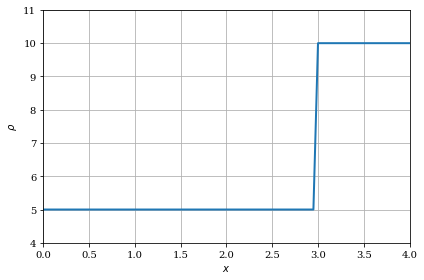

In [5]:
# plot
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
line = pyplot.plot(x, rho0, color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(0.0, L)
pyplot.ylim(4.0, 11.0)
pyplot.tight_layout()

## solve problem

In [6]:
def flux(rho, u_max, rho_max):
    F = rho * u_max * (1.0 - rho / rho_max)
    return F

In [7]:
from matplotlib import animation
from IPython.display import HTML

In [8]:
def update_plot(n, rho_hist):
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])

# Lax-Friedrichs Scheme

Taking average of neighbors value in time derivative.

### sigma = 1.0

In [9]:
def lax_friedrichs(rho0, nt, dt, dx, bc_values, *args):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        F = flux(rho, *args)
        rho[1:-1] = (0.5 * (rho[:-2] + rho[2:]) - dt / (2.0 * dx) * (F[2:] - F[:-2]))
        
        rho[0] = bc_values[0]
        rho[-1] = bc_values[1]
        rho_hist.append(rho.copy())
    return rho_hist

In [10]:
# set CFL
sigma = 1.0
dt = sigma * dx / u_max

rho_hist = lax_friedrichs(rho0, nt, dt, dx, (rho0[0], rho0[-1]), u_max, rho_max)

In [11]:
anim = animation.FuncAnimation(fig, update_plot, frames=nt, fargs=(rho_hist,), interval=100)
HTML(anim.to_html5_video())

1. This solution has a stair edge compared with exact solution.

2. 1st order error

3. The Lax-Friedrichs scheme is good for simulation the senario that we may not able to use by regular method.

### sigma = 0.5

In [12]:
sigma = 0.5
dt = sigma * dx / u_max
rho_hist = lax_friedrichs(rho0, nt, dt, dx, (rho0[0], rho0[-1]), u_max, rho_max)

In [13]:
anim = animation.FuncAnimation(fig, update_plot, frames=nt, fargs=(rho_hist,), interval=100)
HTML(anim.to_html5_video())

### sigma = 0.1

In [14]:
sigma = 0.1
dt = sigma * dx / u_max
rho_hist = lax_friedrichs(rho0, nt, dt, dx, (rho0[0], rho0[-1]), u_max, rho_max)

In [15]:
anim = animation.FuncAnimation(fig, update_plot, frames=nt, fargs=(rho_hist,), interval=100)
HTML(anim.to_html5_video())

With the courant number getting smaller, the stairs are getting smaller.

This is caused by the equation. We are trying to calculate the current value but there is no current value in our equation; we only use their neighbors!

# Lax-Wendroff Scheme

In [16]:
def jacobian(rho, u_max, rho_max):
    J = u_max * (1.0 - 2.0 * rho / rho_max)
    return J

In [17]:
def lax_wendroff(rho0, nt, dt, dx, bc_values, *args):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        F = flux(rho, *args)
        J = jacobian(rho, *args)
        rho[1:-1] = (rho[1:-1] -
                    dt / (2.0 * dx) * (F[2:] - F[:-2]) +
                    dt**2 / (4.0 * dx**2) *
                    ((J[1:-1]+J[2:]) * (F[2:] - F[1:-1]) -
                    (J[:-2] + J[1:-1]) * (F[1:-1] - F[:-2])))
        rho[0] = bc_values[0]
        rho[-1] = bc_values[1]
        rho_hist.append(rho.copy())
    return rho_hist

### sigma = 1

In [18]:
# set parameters
sigma = 1.0
dt = sigma * dx / u_max

rho_hist = lax_wendroff(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                       u_max, rho_max)

In [19]:
anim = animation.FuncAnimation(fig, update_plot,
                              frames=nt, fargs=(rho_hist,),
                              interval=100)

HTML(anim.to_html5_video())

### sigma = 0.5

In [20]:
sigma = 0.5
dt = sigma * dx / u_max

rho_hist = lax_wendroff(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                       u_max, rho_max)

anim = animation.FuncAnimation(fig, update_plot,
                              frames=nt, fargs=(rho_hist,),
                              interval=100)

HTML(anim.to_html5_video())

### sigma = 0.1

In [21]:
sigma = 0.1
dt = sigma * dx / u_max

rho_hist = lax_wendroff(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                       u_max, rho_max)

anim = animation.FuncAnimation(fig, update_plot,
                              frames=nt, fargs=(rho_hist,),
                              interval=100)

HTML(anim.to_html5_video())

# MacCormack Scheme

We predict the solution and we revise it. So there are two steps!

In [22]:
def maccormack(rho0, nt, dt, dx, bc_values, *args):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    rho_star = rho.copy()
    for n in range(nt):
        F = flux(rho, *args)
        rho_star[1:-1] = (rho[1:-1] -
                         dt / dx * (F[2:] - F[1:-1]))
        F = flux(rho_star, *args)
        rho[1:-1] = 0.5 * (rho[1:-1] + rho_star[1:-1] - 
                          dt / dx * (F[1:-1] - F[:-2]))
        rho[0] = bc_values[0]
        rho[-1] = bc_values[1]
        rho_hist.append(rho.copy())
    return rho_hist

### sigma = 1

In [23]:
sigma = 1.0
dt = sigma * dx / u_max

rho_hist = maccormack(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                     u_max, rho_max)

anim = animation.FuncAnimation(fig, update_plot,
                              frames=nt, fargs=(rho_hist,),
                              interval=100)

HTML(anim.to_html5_video())

### sigma = 0.5

In [24]:
sigma = 0.5
dt = sigma * dx / u_max

rho_hist = maccormack(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                     u_max, rho_max)

anim = animation.FuncAnimation(fig, update_plot,
                              frames=nt, fargs=(rho_hist,),
                              interval=100)

HTML(anim.to_html5_video())